# 2D linear  diffusion-reaction example
Jean C. Ragusa

Texas A&M University

jean.ragusa@tamu.edu

# General problem definition
Consider a 2D linear diffusion-reaction:
- it can be a source-driven neutron diffusion problem
  $$ -\frac{d}{dx} D(x,y)\frac{du}{dx}  -\frac{d}{dy} D(x,y)\frac{du}{dy} + \Sigma(x,y) u(x,y) = q(x,y)$$
- it can be a heat conduction problem with convective heat transfer modeled along its length
  $$ -\frac{d}{dx} k(x,y)\frac{du}{dx}  -\frac{d}{dy} k(x,y)\frac{du}{dy} + H(x,y) u(x,y) = H(x,y)*T^\infty(x,y)$$


**Boundary conditions**:
* a natural boundary condition $$ a u + D\partial_n u = c$$
* or a fixed, imposed value $$ u = \text{given}$$

Note that 

* symmetry lines are obtained using $a=0$ and $c=0$.


Further note that
* the convective heat transfer boundary conditions can be written as:
  $$ -D\partial_n T  = h(T - uT^{\infty}) $$
  So $a=h$, the convective heat exchange coefficient, and $c=h T^\infty$, with $T^\infty$ the far-field/ambient value.
* the neutron diffusion incoming boundary is:
  $$\frac{u}{4} +\frac{D}{2}\partial_n u  = J^{inc}$$
  that is, $a=1/2$ and $c=2J^{inc}$, with $J^{inc}$ the incoming current value.



### load python modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time as time

from scipy import sparse
from scipy.sparse import linalg

from matplotlib import cm
from matplotlib.ticker import LinearLocator

# class for data (geometry, material property, mesh)
See example below to understand what to pass to this object

In [2]:
class mydata:
    
    def __init__(self, mat_layout, src_layout, mat_prop, src_prop, nref, L, pb_dim=2):
        # mat_layout: 2D layout of the material (material zones)
        # src_layout: 2D layout of the heat source (source zones)
        #     Note the two layouts must be of compatible shape
        # mat_prop: a 2d array containing the various values for 2 material properties:
        #     mat_prop[0,:] the values for the diffusion coefficient in the various zones
        #     mat_prop[1,:] the values for the reaction coefficient in the various zones
        # src_prop: a 1d array containing the various values for the source properties
        # nref: a list or array of length 2 containing the number of mesh refinement in x and y
        #     Note that mesh refinement is uniform in this code
        # L: a list or array of legnth 2 containing the Lx and Ly dimensions
        
        # sanity checks
        if pb_dim != 2:
            raise ValueError('Only pb_dim=2 for now')
        if mat_layout.ndim !=2:
            raise ValueError('mat_layout: only dim=2 for now')
        if src_layout.ndim !=2:
            raise ValueError('src_layout: only dim=2 for now')
        if mat_layout.shape != src_layout.shape:
            raise ValueError('mat_layout and src_layout of different shapes')
        if len(nref) !=2:
            raise ValueError('nref: only len=2 for now')
        if len(L) !=2:
            raise ValueError('L: only len=2 for now')
        if mat_prop.ndim !=2:
            raise ValueError('mat_prop must be of dim=2 (cidf and siga)')
        if src_prop.ndim !=1:
            raise ValueError('src_prop must be of dim=1 (qext)')
        if len(np.unique(np.reshape(mat_layout,(1,-1)))) != mat_prop.shape[1]:
            raise ValueError('mat_layout/mat_prop not enough properties')
        if len(np.unique(np.reshape(src_layout,(1,-1)))) != len(src_prop):
            raise ValueError('src_layout/src_prop not enough properties')
        
        # refine the mesh and update material and source layouts
        repeats = np.asarray(nref, dtype=int)
        self.mzones = self.repeat_array(mat_layout,repeats)
        self.szones = self.repeat_array(src_layout,repeats)

        # mesh data
        # cells
        self.ncells_x, self.ncells_y = self.mzones.shape
        # vertices
        self.npts_x = self.ncells_x + 1
        self.npts_y = self.ncells_y + 1
        self.n_verts = self.npts_x * self.npts_y 
        # coordinates
        self.x = np.linspace(0,L[0],self.npts_x)
        self.y = np.linspace(0,L[1],self.npts_y)
        
        self.dx = L[0] / self.ncells_x
        self.dy = L[1] / self.ncells_y
        
        # nodal connectivity for cFEM
        self.connectivity()

            
    def repeat_array(self, arr,repeats):
        for dim,n in enumerate(repeats):
            arr = np.repeat(arr,n,axis=dim)
        return arr        
    
    
    def connectivity(self):
        self.n_cells = self.ncells_x * self.ncells_y 
        self.gn = np.zeros((self.n_cells,4),dtype=int)

        # compute node ID from (i,j) cell identifiers
        node = lambda i,j: i+j*self.npts_x

        iel = 0
        for j in range(self.ncells_y):
            for i in range(self.ncells_x):
                # counter-clockwise
                self.gn[iel,0] = node(i  ,j  )
                self.gn[iel,1] = node(i+1,j  )
                self.gn[iel,2] = node(i+1,j+1)
                self.gn[iel,3] = node(i  ,j+1)

                iel += 1    

# class for FEM solver

Most of this is none of your business except the routines:
- assemble_system_per_zone
- combine_system_per_zone

In [21]:
class FEM_solver:
    def __init__(self, data):
        # input: the data object
        
        # store the data received
        self.data = data
        
        # duplicates, shortcuts
        self.ncells_x = data.ncells_x
        self.ncells_y = data.ncells_y

        self.npts_x = data.npts_x
        self.npts_y = data.npts_y
        
        self.n_nodes = data.n_verts
        self.n_cells = data.n_cells
        
        self.dx = data.dx
        self.dy = data.dy

        # compute the cFEM basis functions
        self.basis()
        # compute the elemental matrices
        self.compute_elemental_matrices()

        
    def elem2ij(self,iel,verbose=False):
        # from element ID (iel) get the (i,j) cell integers
        # iel = i + j*nx
        j = int(iel/self.ncells_x)
        i = iel-j*self.ncells_x
        if verbose:
            print("i=",i,", j=",j)
        return i,j
    
    
    def node2ij(self,ivert,verbose=False):
        # from node ID (ivert) get the (i,j) node integers
        # ivert = i +j*npts_x
        j = int(ivert/self.npts_x)
        i = ivert-j*self.npts_x
        if verbose:
            print("i=",i,", j=",j)
        return i,j
    
    
    def basis(self):
        # list of basis functions in [-1,1]^dim in counter-clockwise ordering
        self.b = []
        self.b.append(lambda u,v: (1-u)*(1-v)/4 )
        self.b.append(lambda u,v: (1+u)*(1-v)/4 )
        self.b.append(lambda u,v: (1+u)*(1+v)/4 )
        self.b.append(lambda u,v: (1-u)*(1+v)/4 )
        # their derivatives with respect to u
        self.dbdx = []
        self.dbdx.append(lambda u,v: -(1-v)/4 +0*u)
        self.dbdx.append(lambda u,v:  (1-v)/4 +0*u )
        self.dbdx.append(lambda u,v:  (1+v)/4 +0*u )
        self.dbdx.append(lambda u,v: -(1+v)/4 +0*u )
        # their derivatives with respect to v
        self.dbdy = []
        self.dbdy.append(lambda u,v: -(1-u)/4 +0*v )
        self.dbdy.append(lambda u,v: -(1+u)/4 +0*v )
        self.dbdy.append(lambda u,v:  (1+u)/4 +0*v )
        self.dbdy.append(lambda u,v:  (1-u)/4 +0*v )
        
        
    def compute_elemental_matrices(self,verbose=False):
        # select spatial quadrature
        degree = 8
        [x_,w_] = np.polynomial.legendre.leggauss(degree)

        # matrices
        local_dofs = len(self.b)
        self.Q   = np.zeros(local_dofs)
        self.M   = np.zeros((local_dofs,local_dofs))
        self.Kxx = np.zeros((local_dofs,local_dofs))
        self.Kyy = np.zeros((local_dofs,local_dofs))
        self.Qxm = np.zeros(local_dofs)
        self.Qxp = np.zeros(local_dofs)
        self.Qym = np.zeros(local_dofs)
        self.Qyp = np.zeros(local_dofs)
        self.Bxm = np.zeros((local_dofs,local_dofs))
        self.Bxp = np.zeros((local_dofs,local_dofs))
        self.Bym = np.zeros((local_dofs,local_dofs))
        self.Byp = np.zeros((local_dofs,local_dofs))

        # volumetric load vector (2d integrals)
        for i,fi in enumerate(self.b):
            for (uq,wuq) in zip(x_,w_):
                for (vq,wvq) in zip(x_,w_):
                    self.Q[i]   += wuq*wvq*fi(uq,vq)

        # volumetric matrices (2d integrals)
        for i,(fi,fxi,fyi) in enumerate(zip(self.b,self.dbdx,self.dbdy)):
            for j,(fj,fxj,fyj) in enumerate(zip(self.b,self.dbdx,self.dbdy)):
                for (uq,wuq) in zip(x_,w_):
                    for (vq,wvq) in zip(x_,w_):
                        self.M[i,j]   += wuq*wvq*fi (uq,vq)*fj (uq,vq)
                        self.Kxx[i,j] += wuq*wvq*fxi(uq,vq)*fxj(uq,vq)
                        self.Kyy[i,j] += wuq*wvq*fyi(uq,vq)*fyj(uq,vq)
        # BC matrices (1d integrals)
        for i,fi in enumerate(self.b):
            for (pq,wq) in zip(x_,w_):
                self.Qxm[i] += wq*fi(-1,pq)
                self.Qxp[i] += wq*fi(+1,pq)
                self.Qym[i] += wq*fi(pq,-1)
                self.Qyp[i] += wq*fi(pq,+1)
        for i,fi in enumerate(self.b):
            for j,fj in enumerate(self.b):
                for (pq,wq) in zip(x_,w_):
                    self.Bxm[i,j] += wq*fi(-1,pq)*fj(-1,pq)
                    self.Bxp[i,j] += wq*fi(+1,pq)*fj(+1,pq)
                    self.Bym[i,j] += wq*fi(pq,-1)*fj(pq,-1)
                    self.Byp[i,j] += wq*fi(pq,+1)*fj(pq,+1)

        if verbose:
            print(self.Q)
            print(self.M)
            print(self.Kxx)
            print(self.Kyy)
            print(self.Bxm)
            print(self.Bxp)
            print(self.Bym)
            print(self.Byp)
            print(self.Qxm)
            print(self.Qxp)
            print(self.Qym)
            print(self.Qyp)
            

    def assemble_system_at_once(self, mat_prop, src_prop, bc, verbose=False):
        # assemble the cFEM system
        t1= time.time()
        
        # sanity check
        if len(bc) !=4:
            raise ValueError('bc dictionary must have 4 keys')
                
        # stiffness matrix
        K = sparse.lil_matrix((self.n_nodes, self.n_nodes))
        # rhs
        rhs = np.zeros(self.n_nodes)

        # loop over elements
        for iel in range(self.n_cells):
            icell,jcell = self.elem2ij(iel)
            imat = self.data.mzones[icell,jcell]
            isrc = self.data.szones[icell,jcell]
            mat_cdif_ = mat_prop[0,imat]
            mat_siga_ = mat_prop[1,imat]
            src_prop_ = src_prop[isrc]
            for i,ind_i in enumerate(self.data.gn[iel,:]):
                rhs[ind_i] += src_prop_ * self.dx*self.dy/4. * self.Q[i]
                for j,ind_j in enumerate(self.data.gn[iel,:]):
                    K[ind_i,ind_j] += mat_cdif_*(  self.dy/self.dx*self.Kxx[i,j] \
                                                + self.dx/self.dy*self.Kyy[i,j] )\
                                        + mat_siga_*self.dx*self.dy/4.*self.M[i,j]

        # apply bc
        node = lambda i,j: i+j*self.npts_x
        
        dir_nodes = []
        T_dir = []
        if bc['ymin']['type'] == 'dirichlet':
            for i in range(self.npts_x):
                dir_nodes.append( node(i,0) )
                T_dir.append(bc['ymin']['value'])
        elif bc['ymin']['type'] == 'robin':
            for iel in np.arange(0,self.ncells_x):
                for i,ind_i in enumerate(self.data.gn[iel,:]):
                    rhs[ind_i] += 2 * bc['ymin']['value'] * self.dx/2. * self.Qym[i]
                    for j,ind_j in enumerate(self.data.gn[iel,:]):
                        K[ind_i,ind_j] += 0.5 * self.dx/2.*self.Bym[i,j]
                        # the 0.5 is from Phi/2

        if bc['ymax']['type'] == 'dirichlet':
            for i in range(self.npts_x):
                dir_nodes.append( node(i,self.npts_y-1) )
                T_dir.append(bc['ymax']['value'])
        elif bc['ymax']['type'] == 'robin':
            for iel in np.arange((self.ncells_y-1)*self.ncells_x,self.n_cells):
                for i,ind_i in enumerate(self.data.gn[iel,:]):
                    rhs[ind_i] += 2 * bc['ymax']['value'] * self.dx/2. * self.Qyp[i]
                    for j,ind_j in enumerate(self.data.gn[iel,:]):
                        K[ind_i,ind_j] += 0.5 * self.dx/2.*self.Byp[i,j]

        if bc['xmin']['type'] == 'dirichlet':
            for j in range(self.npts_y):
                dir_nodes.append( node(0,j) )
                T_dir.append(bc['xmin']['value'])
        elif bc['xmin']['type'] == 'robin':
            for iel in np.arange(0,(self.ncells_y-1)*self.ncells_x+1,self.ncells_x):
                for i,ind_i in enumerate(self.data.gn[iel,:]):
                    rhs[ind_i] += 2 * bc['xmin']['value'] * self.dy/2. * self.Qxm[i]
                    for j,ind_j in enumerate(self.data.gn[iel,:]):
                        K[ind_i,ind_j] += 0.5 * self.dy/2.*self.Bxm[i,j]

        if bc['xmax']['type'] == 'dirichlet':
            for j in range(self.npts_y):
                dir_nodes.append( node(self.npts_x-1,j) )
                T_dir.append(bc['xmax']['value'])
        elif bc['xmax']['type'] == 'robin':
            for iel in np.arange(self.ncells_x-1,self.n_cells,self.ncells_x):
                for i,ind_i in enumerate(self.data.gn[iel,:]):
                    rhs[ind_i] += 2 * bc['xmax']['value'] * self.dy/2. * self.Qxp[i]
                    for j,ind_j in enumerate(self.data.gn[iel,:]):
                        K[ind_i,ind_j] += 0.5 * self.dy/2.*self.Bxp[i,j]
                
        # dirichlet 
        dir_nodes = np.asarray(dir_nodes)

        for i,inode in enumerate(dir_nodes):
            K[inode,:]     = 0.
            K[inode,inode] = 1.
            rhs[inode]     = T_dir[i]

        if verbose:
            print("time to assemble = ",time.time()-t1)
        
        return K, rhs

    
    def assemble_system_per_zone(self, bc, verbose=False):

        # your job
        
        return K_list, M_list, K_bc, rhs_list, rhs_bc

                
    def combine_system_per_zone(self, mat_prop, src_prop, bc, K_list, M_list, K_bc, \
                                rhs_list, rhs_bc, verbose=False):
        # your job

        return A, rhs

    
    def solve_system(self, A, b, verbose=False):
        t1= time.time()

        # solve linear system
        if sparse.isspmatrix_csc(A):
            if verbose:
                print("It's a CSC matrix.")
            T  = linalg.spsolve(A, b)   
        elif sparse.isspmatrix_lil(A):
            if verbose:
                print("It's a LIL matrix.")
            T  = linalg.spsolve(A.tocsc(), b)   
        elif isinstance(A, sparse.spmatrix):
            if verbose:
                print("It's a generic sparse matrix.")
            T  = linalg.spsolve(A.tocsc(), b)   
        elif isinstance(A, np.ndarray):
            if verbose:
                print("It's a NumPy ndarray.")
            T  = np.linalg.solve(A, b)   
        else:
            if verbose:
                print("It's not a recognized sparse matrix type or a NumPy ndarray.")    

        if verbose:
            print("time to solve    = ",time.time()-t1)
        
        return T   
    
    
    def plot(self, sol):

        # plot in 2D
        XX,YY = np.meshgrid(self.data.x,self.data.y)
        TT = np.reshape(sol,(self.data.npts_y,self.data.npts_x))

        # figsizes
        sx = 3
        sy = sx * (np.max(d.y)-np.min(d.y))/ (np.max(d.x)-np.min(d.x))

        # Plot the surface.
        fig, ax = plt.subplots(figsize=(3*sx, 3*sy),subplot_kw={"projection": "3d"})
        surf = ax.plot_surface(XX.T, YY.T, TT.T, cmap=cm.coolwarm,
                               linewidth=1)#, antialiased=False)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        # Customize the z axis.
        zmin,zmax = np.min(sol),np.max(sol)
        if np.abs(zmin-zmax)<1e-6:
            zmin,zmax = -0.1, 0.1
        ax.set_zlim(zmin,zmax)
        ax.zaxis.set_major_locator(LinearLocator(10))
        # A StrMethodFormatter is used automatically
        ax.zaxis.set_major_formatter('{x:.02f}')
        # rotate as needed
        ax.view_init(30,-60)
        ax.set_box_aspect(aspect=(1, sy/sx, 1))
        # Add a color bar which maps values to colors.
        fig.colorbar(surf, shrink=0.2, aspect=5)
        plt.show()

# Example 1

time to assemble =  1.370521068572998
It's a LIL matrix.
time to solve    =  0.04597783088684082


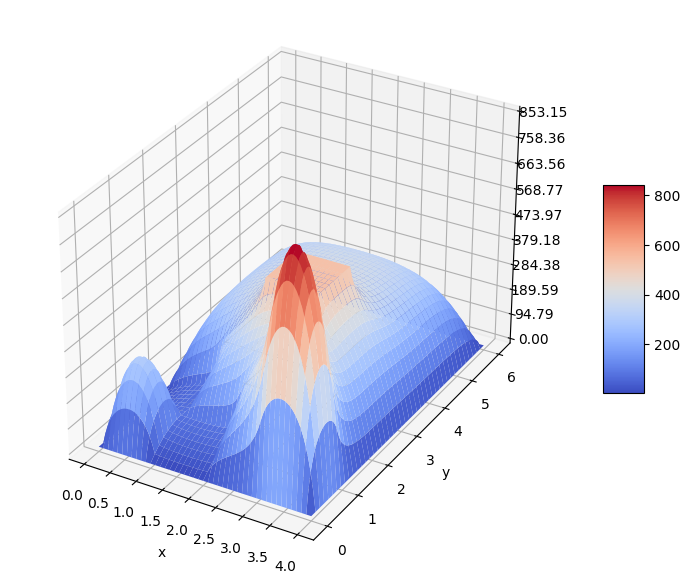

In [22]:
# data

# layout first
mat_layout = np.zeros((4,6),dtype=int)
mat_layout[1,0] = 1
mat_layout[2,2] = 2
mat_layout[0,1] = 1
# then values
mat_prop = np.zeros((2,3))
mat_prop[0,:] = 0.01, 0.3 , 10.
mat_prop[1,:] = 0.05, 0.05,  0.

# layout
src_layout = np.zeros_like(mat_layout,dtype=int)
src_layout[0,0] = 1
src_layout[3,0] = 2
# then values
src_prop = np.array([20., 50., 100.])

# create data and solver objects
d = mydata(mat_layout, src_layout, mat_prop, src_prop, [22,22], [4.,6.])
solver = FEM_solver(d)

# bc
bc = {}
bc['xmin']={'type':'dirichlet','value':0.}
bc['xmax']={'type':'dirichlet','value':0.}
bc['ymin']={'type':'dirichlet','value':0.}
bc['ymax']={'type':'dirichlet','value':0.}

# solve
A,b = solver.assemble_system_at_once(mat_prop, src_prop, bc, verbose=True)
solution = solver.solve_system(A, b, verbose=True)
solver.plot(solution)

#  affine decomposition of LINEAR operators
Once you job is done, test it

##### here you see the stifness matrices, mass matrices, and boundary matrices
Note that I use a very coarse mesh: [1,1]

time to assemble =  0.022938966751098633


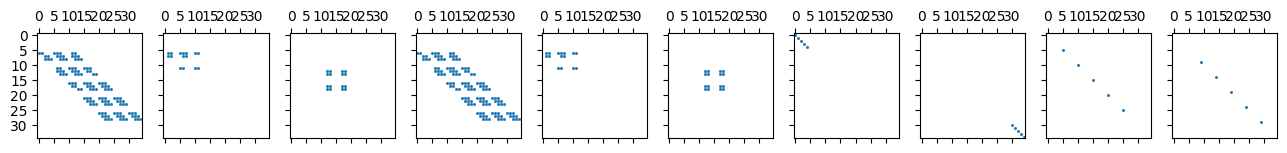

In [24]:
d = mydata(mat_layout, src_layout, mat_prop, src_prop, [1,1], [4.,6.])
solver = FEM_solver(d)
K_list, M_list, K_bc, rhs_list, rhs_bc = solver.assemble_system_per_zone(bc, verbose=True)

fig, axs = plt.subplots(1, len(K_list+M_list+K_bc), sharey=True, figsize=(16,9))
axs = axs.flatten()
for ax,K in zip(axs,K_list+M_list+K_bc):
    ax.spy(K,ms=1)

time to assemble =  1.3723220825195312
It's a LIL matrix.
time to solve    =  0.046431779861450195


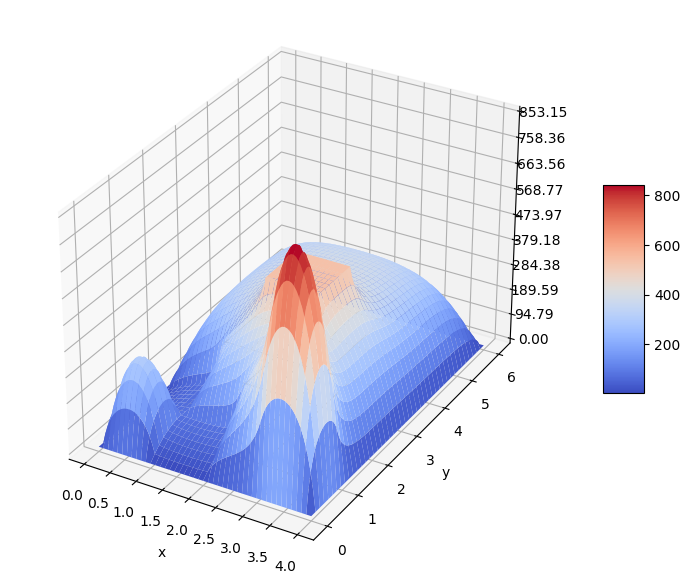

time to assemble =  6.716856956481934
time to combine  =  0.00398564338684082
It's a CSC matrix.
time to solve    =  0.04388713836669922


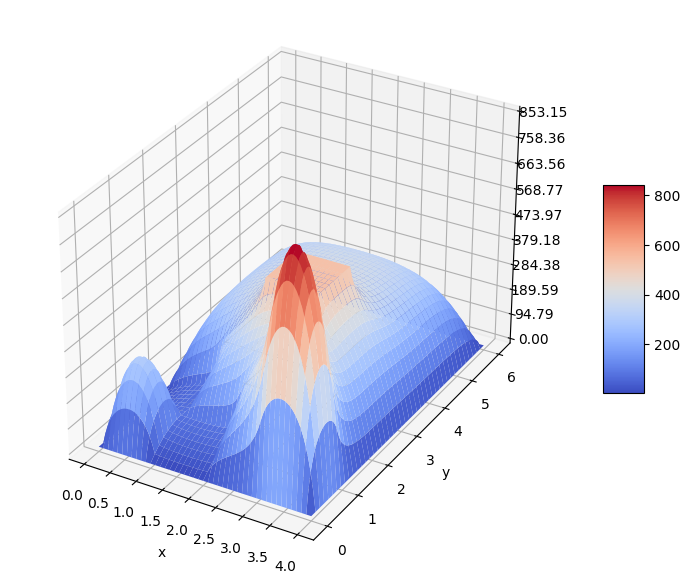

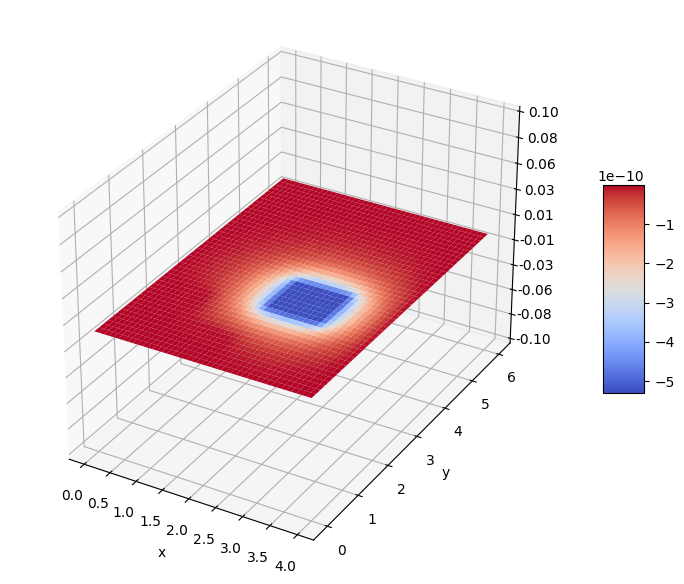

In [25]:
# create data and solver objects
mat_prop[0,:] = 0.01, 0.3 , 10.
mat_prop[1,:] = 0.05, 0.05,  0.

# go back to a fine mesh
d = mydata(mat_layout, src_layout, mat_prop, src_prop, [22,22], [4.,6.])
solver = FEM_solver(d)

# solve FOM
A,b = solver.assemble_system_at_once(mat_prop, src_prop, bc, verbose=True)
FOMsolution = solver.solve_system(A, b, verbose=True)
solver.plot(FOMsolution)

# solve affine FOM
K_list, M_list, K_bc, rhs_list, rhs_bc = solver.assemble_system_per_zone(bc, verbose=True)
A_,b_ = solver.combine_system_per_zone(mat_prop, src_prop, bc, K_list, M_list, K_bc, \
                                rhs_list, rhs_bc, verbose=True)

FOMsolution_affine = solver.solve_system(A_, b_, verbose=True)
solver.plot(FOMsolution_affine)

# make sure the FOM solutions are the same
solver.plot(FOMsolution_affine-FOMsolution)

# Create intrusive ROM
We do not use affine decomposition here. Thus, the original system of equations (matrix size $N\times N$)
$$ A(\mu) \Phi^{\mu} = b(\mu)$$
gets Galerkin-projected into
$$ U^TA(\mu) U c^{\mu} = U^Tb(\mu)$$
where we used the fact that the new solution is sought as
$$ \Phi^{\mu} = U c^{\mu} = \sum_{i=1}^{i=r} u_i c_i^{\mu}$$
with $u_i$ the global basis (vectors of same length as the $\Phi$ vector) and $c_i^{\mu}$ the expansion coefficients that depend on the new parameter $\mu$. $r$ is the rank retained in our approximation.


Note that the above projected system is a system of much smaller size (matrix size $r\times r$)
$$ A_r(\mu) = U^TA(\mu) U \qquad b_r(\mu)= U^Tb(\mu)$$

Reconstruction part: once the $c_i^{\mu}$  are obtained, the full-length solution is given by $ \Phi^{\mu} = U c^{\mu}$

# Compute the reduced operators for the affine decomposition approach (linear operator and rhs only)

In [26]:
def compute_reduced_operator_affine(U, K_list, M_list, K_bc, rhs_list, rhs_bc):

    # your job

    return Kr_list, Mr_list, Kr_bc, rhsr_list, rhsr_bc

In [27]:
def solve_intrusive_rom_affine(U, sample, bc, Kr_list, Mr_list, Kr_bc, rhsr_list, rhsr_bc):
    
    # your job

    return T_recons

# Let's generate some snapshots

# sampling

In [28]:
import random as random
np.random.seed(123456789)

In [29]:
n_samples = 500

n_properties = 3  # D, siga, q
n_input = 2 * mat_prop.shape[1] + len(src_prop)
min_vals = np.hstack((mat_prop[0,:], mat_prop[1,:], src_prop))
max_vals = 2.0 * min_vals

samples = np.random.uniform(low=np.expand_dims(min_vals,axis=0), high=np.expand_dims(max_vals,axis=0), \
                               size=(n_samples,n_input) )

n_train = int(0.8*n_samples)
n_test = n_samples - n_train
x_train = samples[:n_train,:]
x_test  = samples[n_train:,:]

print('shapes of training and testing params:',samples.shape,x_train.shape,x_test.shape,"\n")
for line in samples[:5,:]:
    print(", ".join(f"{val:.3f}" for val in line))

shapes of training and testing params: (500, 9) (400, 9) (100, 9) 

0.015, 0.460, 15.096, 0.086, 0.063, 0.000, 37.678, 57.745, 167.055
0.016, 0.517, 17.487, 0.091, 0.055, 0.000, 24.616, 50.613, 135.354
0.012, 0.538, 16.122, 0.095, 0.066, 0.000, 39.605, 77.103, 124.229
0.013, 0.470, 11.333, 0.094, 0.074, 0.000, 37.844, 91.382, 197.997
0.019, 0.358, 14.545, 0.090, 0.087, 0.000, 24.409, 99.898, 160.280


# generate snapshots

In [34]:
T_snapshots = np.zeros((solver.n_nodes,n_samples))

t0 = time.time()
# loop to generate snapshots

        # your job

print("Time spent generating {} snapshots with affine-FOM = {}".format(n_samples,time.time()-t0))

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:23<00:00, 21.17it/s]

Time spent generating 500 snapshots with affine-FOM = 23.623627185821533


# Perform SVD on data collected (only training portion)

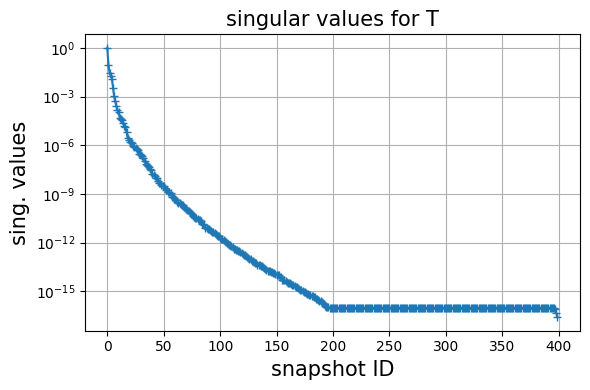

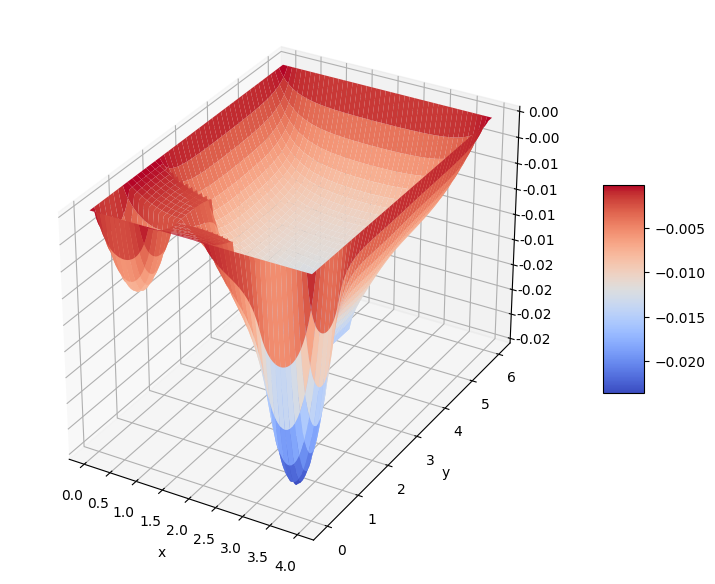

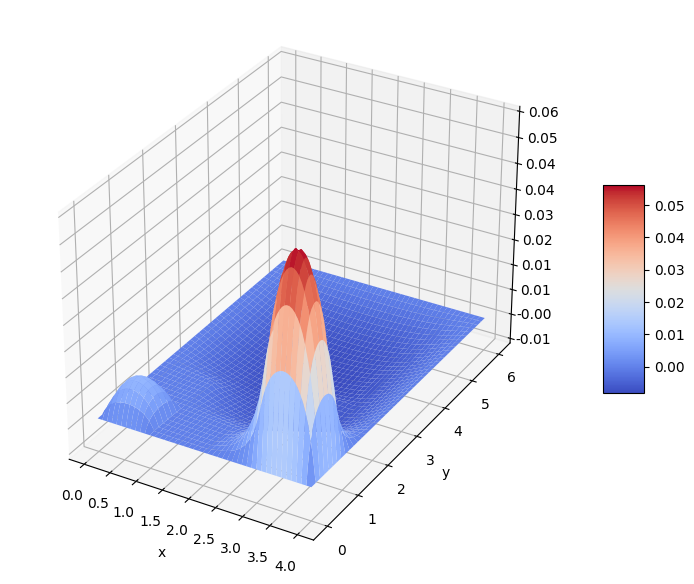

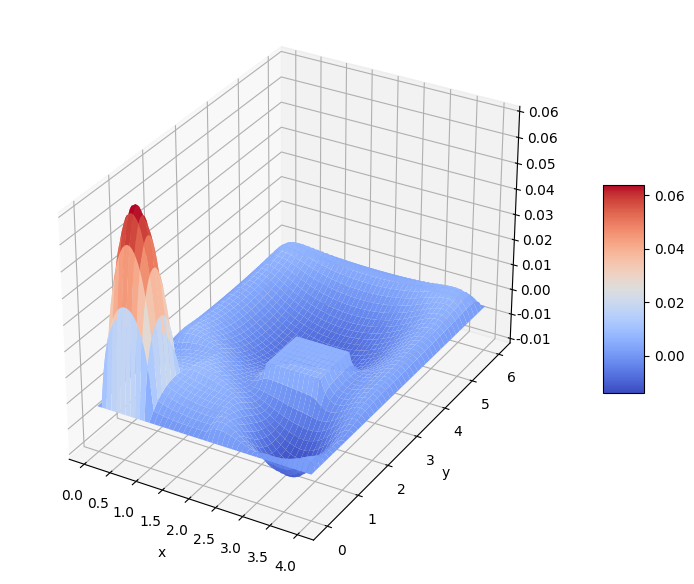

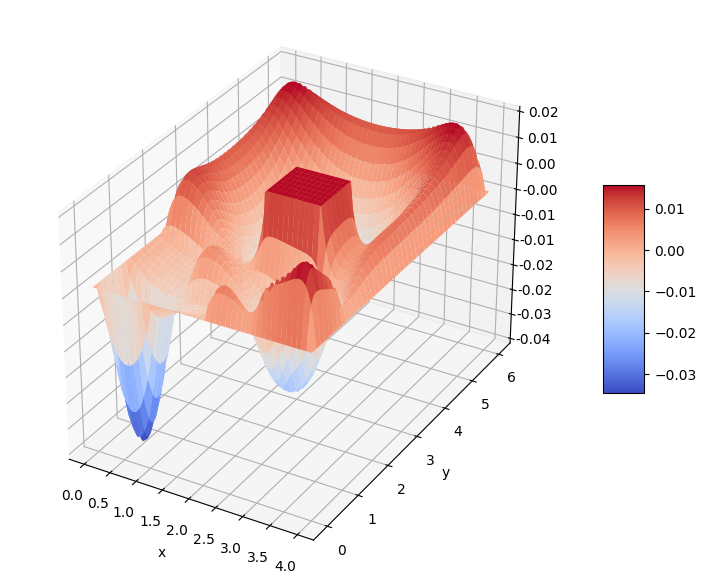

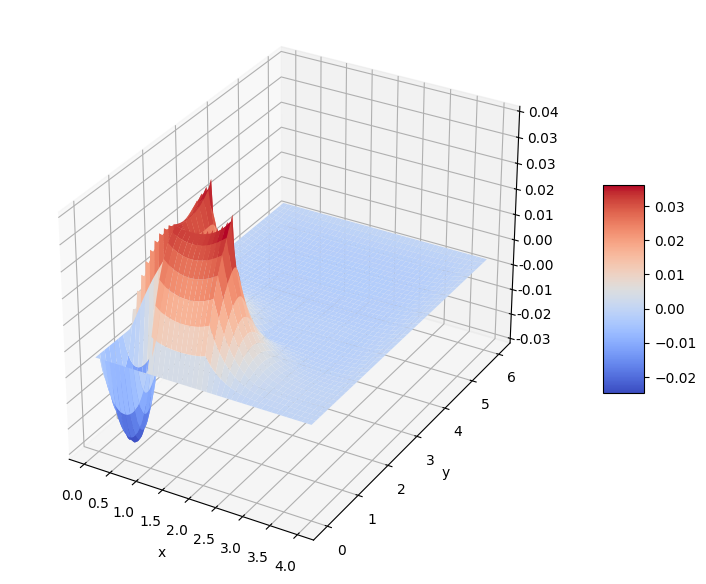

In [36]:
# your job

## Pick rank and build reduced system

In [38]:
# your job

Reduced order model with 5 modes:
Singular value fraction = 0.994984


## Testing

In [39]:
def test_intrusive_rom(U, Test_samples, Truth, bc, Kr_list, Mr_list, Kr_bc, rhsr_list, rhsr_bc):
    # Storage for reduced order solutions and stats
    Emax = -np.inf
    Emin = np.inf
    Eavg = 0
    T_rom = np.zeros((Truth.shape))
    n_test = Test_samples.shape[0]
    Err_ = np.zeros(n_test)

     # Compute for each point in reference
    t0 = time.time()
    for i in range(n_test):
        T_rom[:,i] = solve_intrusive_rom_affine(U, Test_samples[i,:], bc, Kr_list, Mr_list, Kr_bc, rhsr_list, rhsr_bc)
        
        # Compute stats/best/worst/etc
        norm = np.linalg.norm(T_rom[:,i] - Truth[:,i]) / np.linalg.norm(Truth[:,i])
        if norm > Emax:
            Emax = norm
        if norm < Emin:
            Emin = norm
        Eavg += norm
        Err_[i] = norm
    Eavg /= n_test
    
    print('\nTotal time using affine decomposition =',time.time()-t0)

    print('  Emin = {:.4e}'.format(Emin))
    print('  Emax = {:.4e}'.format(Emax))
    print('  Eavg = {:.4e}\n'.format(Eavg))
    
    return Err_

In [41]:
err_intrusive = test_intrusive_rom(U_all[:,:rk], samples[n_train:,:], T_snapshots[:,n_train:], \
                                   bc, Kr_list, Mr_list, Kr_bc, rhsr_list, rhsr_bc)


Total time using affine decomposition = 0.03902554512023926
  Emin = 3.5708e-04
  Emax = 1.3499e-02
  Eavg = 3.1569e-03



## test ROM with different ranks and using unseen data

Reduced order model with 5 modes:
Singular value fraction = 0.994984

Total time using affine decomposition = 0.037242889404296875
  Emin = 3.5708e-04
  Emax = 1.3499e-02
  Eavg = 3.1569e-03

Reduced order model with 10 modes:
Singular value fraction = 0.999736

Total time using affine decomposition = 0.034906864166259766
  Emin = 3.4400e-05
  Emax = 1.5752e-03
  Eavg = 2.2815e-04

Reduced order model with 15 modes:
Singular value fraction = 0.999956

Total time using affine decomposition = 0.03524136543273926
  Emin = 8.6401e-06
  Emax = 2.7461e-04
  Eavg = 8.8178e-05

Reduced order model with 20 modes:
Singular value fraction = 0.999992

Total time using affine decomposition = 0.037334442138671875
  Emin = 1.3020e-06
  Emax = 4.9062e-05
  Eavg = 5.9667e-06

Reduced order model with 50 modes:
Singular value fraction = 1.000000

Total time using affine decomposition = 0.04908871650695801
  Emin = 5.4791e-09
  Emax = 1.1374e-07
  Eavg = 2.1354e-08

Reduced order model with 75 modes:
Sin

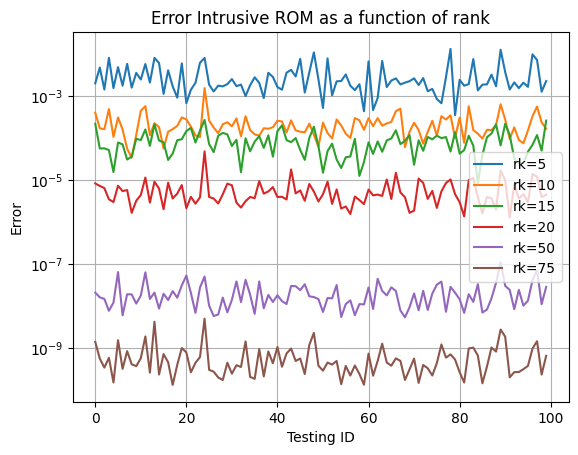

In [42]:
rk_list = [5,10,15,20,50,75]
plt.figure()


for rk in rk_list:
    # for each rank, compute red operators:
    Kr_list, Mr_list, Kr_bc, rhsr_list, rhsr_bc = compute_reduced_operator_affine(U_all[:,:rk], \
                                                                           K_list, M_list, K_bc, rhs_list, rhs_bc)

    err_intrusive = test_intrusive_rom(U_all[:,:rk], samples[n_train:,:], T_snapshots[:,n_train:], \
                                       bc, Kr_list, Mr_list, Kr_bc, rhsr_list, rhsr_bc)
    
    plt.semilogy(err_intrusive, label='rk='+str(rk))
    
plt.grid(True)
plt.title('Error Intrusive ROM as a function of rank')
plt.xlabel('Testing ID')
plt.ylabel('Error')
plt.legend()
plt.show()